## Define Needed Functions

### Import Needed Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import networkx as nx
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import ssl
import pickle

## Make Graph

### Loading in the Data

To start making a graph we must read in our given data and pick out the individual threads in the online forum

In [2]:
data = pd.read_csv("GawaherSentiment.csv")
threads = data["ThreadID"].unique()

### Creating nodes and edges

Next, we have to create the nodes and edges for the graph. The sentiment of each thread is taken to get node values and edges are created by finding threads with common memembers. The edges are weighted by the number of shared members between threads.

In [19]:
edges = []
weights = []
for i in range(0,len(threads)):
    for j in range(0, len(threads)):
        if i % 100 == 0 and j == 0:
            print(i)
            
        if i >= j:
            pass
        else:
            thread1 = data[data["ThreadID"] == threads[i]]["MemberID"]
            thread2 = data[data["ThreadID"] == threads[j]]["MemberID"]
            intersection = len(np.intersect1d(thread1,thread2))
            if intersection > 0:
                edges.append([threads[i],threads[j]])
                weights.append(intersection)
                
        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [3]:
threadSentiments = []
for i in threads:
    threadSentiments.append(np.mean(data[data["ThreadID"]==i]["AllenNLP"]))
    

In [4]:
nodeDict = dict(zip(data["ThreadID"],np.around(threadSentiments,4)))

In [5]:
edges = np.genfromtxt('interEdges.csv', delimiter=',')
weights =  np.genfromtxt('interWeights.csv', delimiter=',')

## Creating and plotting Graph

The the nodes and edges, networkX can create and plot the graph 

G = nx.Graph()
G.add_nodes_from(threads)
G.add_edges_from(edges)
edgeDict = dict(zip(G.edges,weights))

plt.figure(figsize = (12,12))
pos=nx.spring_layout(G)
nx.draw(G,pos, labels = nodeDict, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edgeDict, label_pos=0.5, font_size = 12);


## Get Statistics

With the graph made, statistics can be taken from it. Specifically, this code is going to look at if similarly sentimented threads are connected to each other.

A connectivity function was created to take in sentiments between nodes and edge weights to calculated weighted and unweighted connectivity.

In [6]:
def connectivity(edgeSentiments,weights):
    """
    Gets all connections between threads in forum data set
    
    Parameters
    ----------
    edgeSentiments: List
        A list of sentiments on each end of an edge [[sentiment, sentiment],[sentiment, sentiment]...]
    
    weights: List
        List of all edge weights
        
    Returns
    -------
    ints
        number of positve-postive, negative-negative, and positive-negative connections
    
    """
    
    posPos = 0
    negNeg = 0
    posNeg = 0
    
    index = 0
    for pair in edgeSentiments:
        if np.sign(pair[0]) == np.sign(pair[1]) and np.sign(pair[0]) == 1:
            posPos += 1*weights[index]
        elif np.sign(pair[0]) == np.sign(pair[1]) and np.sign(pair[0]) == -1:
            negNeg += 1*weights[index]
        elif np.sign(pair[0]) != np.sign(pair[1]) and pair[0] != 0 and pair[1] != 0:
            posNeg += 1*weights[index]
        index += 1
    return posPos,negNeg, posNeg



In [22]:
flatEdges = np.concatenate(edges)
flatSentiments = np.array(threadSentiments)
edgeSentiments = np.sort(flatSentiments.reshape(-1,2))
uniqueWeights = np.full(len(weights),1)
 
allConnection = list(connectivity(edgeSentiments,weights))
uniqueConnection = list(connectivity(edgeSentiments,uniqueWeights))

### Visualize Statistics

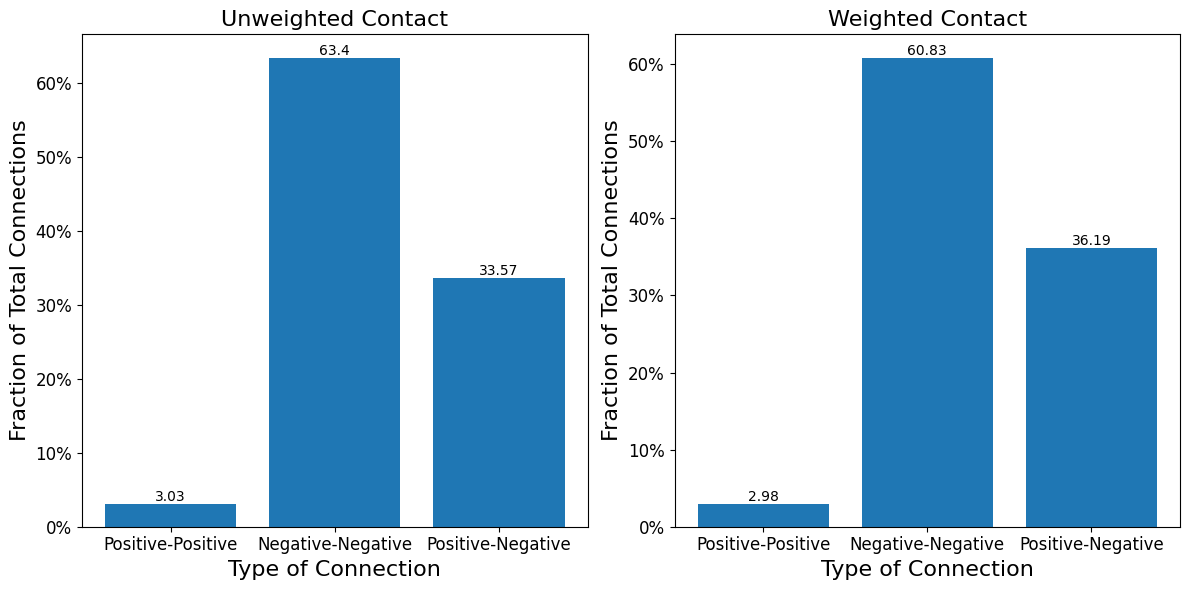

In [25]:
font = 16
tick = 12

plt.figure(figsize = (12,6))

plt.subplot(1,2,2)

plot1 = plt.bar(["Positive-Positive","Negative-Negative","Positive-Negative"],allConnection/np.sum(allConnection))
plt.title("Weighted Contact", fontsize = font)
plt.ylabel("Fraction of Total Connections", fontsize = font)
plt.xlabel("Type of Connection", fontsize = font)
plt.bar_label(plot1,np.around(np.array(allConnection)*100/np.sum(allConnection),2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)


plt.subplot(1,2,1)
plot2 = plt.bar(["Positive-Positive","Negative-Negative","Positive-Negative"],uniqueConnection/np.sum(uniqueConnection))
plt.title("Unweighted Contact", fontsize = font)
plt.ylabel("Fraction of Total Connections", fontsize = font)
plt.xlabel("Type of Connection", fontsize = font)
plt.bar_label(plot2,np.around(np.array(uniqueConnection)*100/np.sum(uniqueConnection),2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)


plt.tight_layout()
plt.savefig("interThread.png")

(array([ 19., 227., 578., 571., 285., 132.,  79.,  58.,  19.,  10.]),
 array([-0.71252889, -0.55765274, -0.40277658, -0.24790043, -0.09302427,
         0.06185188,  0.21672804,  0.37160419,  0.52648035,  0.6813565 ,
         0.83623265]),
 <BarContainer object of 10 artists>)

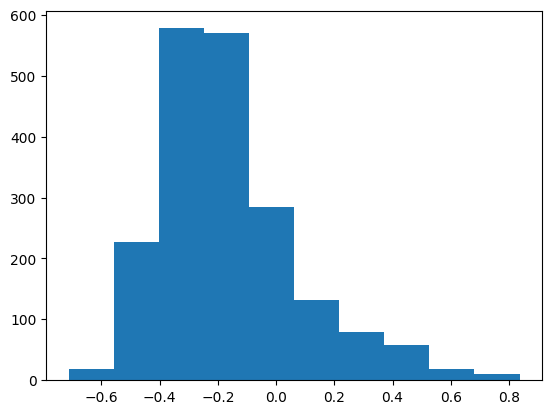

In [24]:
plt.hist(threadSentiments)